# ASR Labs 3 and 4 &ndash; Viterbi decoding

In these labs we'll use the experience &ndash; and code &ndash; you have developed in previous labs to develop your own Viterbi decoder.  You'll want to refer back to [Lecture 5](http://www.inf.ed.ac.uk/teaching/courses/asr/2020-21/asr05-hmm-algorithms.pdf).  Remember that the Viterbi algorithm is used to find the joint probability of an observation sequence $X$ and the **best** path single path $Q$, allowing this best path to be efficiently discovered. 

Your decoder will find the best path through the WFST representations HMMs that you developed in Labs 1 and 2.  In the case that your WFST is just a linear chain, the best path will provide an *alignment* of the observation sequence to the HMM states.  If your WFST is a set of word or phone loops (or any other structure) then the best path will allow you to recover the most likely transcription for the observed acoustic features, subject to the constraints of your grammar and vocabulary.

Observation probabilities $b_j(t)$ will be supplied for you &ndash; you do not need to use the observations $(x_1, \dotsc x_T)$ directly.  These are supplied via the `observation_model` module.  You can use this as follows:

```python
import observation_model

my_om = observation_model.ObservationModel()

my_om.load_audio('filename.wav')  

# or use dummy audio for debugging
my_om.load_dummy_audio()  # will generate dummy observations as seen in Lab 2, 
                          # useful for testing
    
my_om.observation_length()  # returns the sequence length, T  

my_om.log_observation_probability(hmm_label, t)  # returns log b_j(t) given HMM label in string form
                                                 # raises IndexError if t > T
                                                 # raises KeyError if hmm_label is not known
```


It's easiest to write your decoder as a Python class, and we will supply a template below.

In [ ]:
partner = "s1922482"

In [ ]:
!pip install numpy

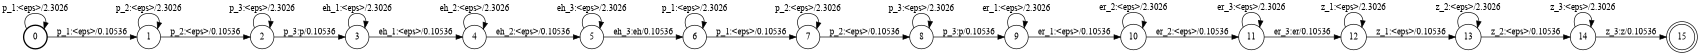

In [8]:
import openfst_python as fst
from subprocess import check_call
from IPython.display import Image
import math
import random
 

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.

    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z
 
    Returns:
        lex (dict): dictionary mapping words to list of phones
    """

    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex
 
lex = parse_lexicon('lexicon.txt')
 

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon

    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM

    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    state_table.add_symbol('<eps>') 
    phone_table.add_symbol('<eps>') 
    word_table.add_symbol('<eps>') 

    for word, phones in lexicon.items():
        word_table.add_symbol(word)
        for phone in phones:
            phone_table.add_symbol(phone)
            for i in range(1, n+1):
                state_table.add_symbol('{}_{}'.format(phone,i))
 
    return word_table, phone_table, state_table
 
word_table, phone_table, state_table = generate_symbol_tables(lex)
 

def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.

    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM excluding start and end

    Returns:
        the final state of the FST
    """

    current_state = start_state
    out_label = phone_table.find(phone)
    weight1 = fst.Weight('log', -math.log(0.1))
    weight2 = fst.Weight('log', -math.log(0.9))


    for i in range(1, n+1):

        in_label = state_table.find('{}_{}'.format(phone, i))
        f.add_arc(current_state, fst.Arc(in_label, 0, weight1, current_state))
        new_state = f.add_state()
        if i == n:
            f.add_arc(current_state, fst.Arc(in_label, out_label, weight2, new_state))
        else:
            f.add_arc(current_state, fst.Arc(in_label, 0, weight2, new_state))
        current_state = new_state
 
    
    return current_state
 
def generate_word_wfst(f, start_state, word, n):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs.
        This will currently output phone labels.  
 
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        word (str): the word to generate
        n (int): states per phone HMM

    Returns:
        the constructed WFST

    """
 
    current_state = start_state

    phones = lex[word]
    for phone in phones:
        current_state = generate_phone_wfst(f, current_state, phone, n)
    f.set_final(current_state)

    return f
 

f = fst.Fst('log')
start = f.add_state()
f.set_start(start)
 
generate_word_wfst(f, start, 'peppers', 3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng', '-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

In [9]:
import observation_model
import math
import numpy as np

class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
    
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)
        
        self.B_j = []
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(range(self.f.num_states())) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                  
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        # RECURSION: Slide 11
        # V_j(t) = max_i V_i(t-1) * a_{ij} * b_j(x_t)
        # B_j(t) = argmax_i V_i(t-1) * a_{ij} * b_j(x_t)
        for j in range(self.f.num_states()):
            prevs = []
            for i in range(self.f.num_states()):
                a_ij = self.NLL_ZERO
                b_jt = self.NLL_ZERO
                for arc in self.f.arcs(i):
                    if arc.nextstate == j:
                        a_ij = float(arc.weight)
                        hmm_label = state_table.find(arc.ilabel)
                        b_jt = self.om.log_observation_probability(hmm_label, t)
                prevs.append(self.V[t-1][i] + a_ij + b_jt)
            state = np.argmax(prevs)
            self.B_j.append(state)
            self.V[t][j] = max(prevs)
    
    def finalise_decoding(self):
        # TERMINATION: Slide 11
        self.B_j[-1] = np.argmax(self.V[-1])
        self.V[-1] = None # [0.0 for p in self.V[-1] if p == self.B_j[-1] else self.NLL_ZERO]
    
    def decode(self):
        
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        
        self.finalise_decoding()
    
    def backtrace(self):
        
        # TODO - exercise 
        
        # complete code to trace back through the
        # best state sequence
        
        # You'll need to create a structure B_j(t) to store the 
        # back-pointers (see lectures), and amend the functions above to fill it.
        return self.B_j # maybe reversed(self.B_j)?
        

# to call the decoder (in a dummy example)
# f will be a WFST that you have created in a previous lab
decoder = MyViterbiDecoder(f, '')   # empty string '' just means use dummy probabilities for testing
decoder.decode()
print(decoder.backtrace())

FileNotFoundError: [Errno 2] No such file or directory: '/group/teaching/asr/labs/tdnnf_mono_net//conf/pdfsmap'

## Exercises &ndash; Lab 3

The `__init__()`, `initialise_decoding()` and `decode()` functions have been completed in the template above.
You should aim to complete the `forward_step()` and `finalise_decoding()` functions for Lab 3.  Don't worry about implementing the back-trace in Lab 3.

You should draw on your solutions to Lab 2 &ndash; the main difference now is that, rather than simply sampling a single path and computing its likelihood, you'll need to compute and store, at every time step $t$, and for every state in the WFST, the likelihood of the best path reaching that state after $t$ time steps.  For how to do this using the Viterbi algorithm, see Lecture 5, slides 11 onwards.

Test your algorithms on an WFST that recognises the word "*pepper*" and one that recognises any word in the vocabulary.


## Exercises &ndash; Lab 4

Now complete the `backtrace()` function to allow the best path to be recovered.  As noted in the code, you'll need to create a structure to store $B_j(t)$, which stores the identity of the best preceding state reaching state $j$ at time $t$ .  You can follow a similar method to storing $V_j(t)$, given in the code already.  You'll need to add it to the `initialise_decoding()`, `forward_step()` and `finalise_decoding()` functions.

Once you are happy that your function works, you should amend your code so that you can also recover the sequence of *output* symbols on your WFST's best path as well.  This should allow you to produce your first word-recognition result!

### Working on real speech

You can now find the first batch of recordings made by ASR students in `/group/teaching/asr/labs/recordings`.  You can test your decoder on real speech data by passing the full path to the WAV file when you create your `MyViterbiDecoder` object.  The transcriptions are also available in the same folder.

When working with real speech, you may want to modify your code to print only the word output labels! 

If you are interested, the observation model (kindly supplied by Andrea) is a monophone time-delay neural network trained using the lattice-free MMI criterion, on the WSJ corpus of read speech.



